# Setup: Install Dependencies

In [ ]:
!pip install -q transformers evaluate accelerate rouge_score nltk bert_score sentencepiece
!pip install -U datasets

# Load Full RAG-Instruct Dataset

In [ ]:
from datasets import load_dataset

finetune_dataset = load_dataset("FreedomIntelligence/RAG-Instruct", split="train")
finetune_dataset = finetune_dataset.train_test_split(test_size=0.3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.64k [00:00<?, ?B/s]

rag_instruct.json:   0%|          | 0.00/296M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40541 [00:00<?, ? examples/s]

# Load Tokenizer & Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Preprocess for Training

In [ ]:
def preprocess(example):
    inputs = tokenizer(example["question"], truncation=True, padding="max_length", max_length=128)
    targets = tokenizer(example["answer"], truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_train = finetune_dataset["train"].map(preprocess, batched=True)


tokenized_train = finetune_dataset["train"].map(preprocess, batched=True)

Map:   0%|          | 0/28378 [00:00<?, ? examples/s]

# Fine-Tuning Setup

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="./flan-t5-small-finetuned",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    logging_steps=50,
    save_strategy="epoch",
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

<ipython-input-10-35a3ec8f1115>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
50,9.535000
100,5.534200
150,4.050100
200,3.524900
250,3.223300
300,3.026200
350,2.915100
400,2.779300
450,2.732900
500,2.705700


TrainOutput(global_step=21285, training_loss=2.434104067063371, metrics={'train_runtime': 1865.8575, 'train_samples_per_second': 45.627, 'train_steps_per_second': 11.408, 'total_flos': 3956400556867584.0, 'train_loss': 2.434104067063371, 'epoch': 3.0})

In [ ]:
from google.colab import files
import shutil

save_path = "./flan-t5-small-finetuned"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

shutil.make_archive("flan-t5-small-finetuned", 'zip', "./flan-t5-small-finetuned")
files.download("flan-t5-small-finetuned.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation from RAG-Instruct test split

In [23]:
import random
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoConfig
)

In [ ]:
from datasets import load_dataset

raw_full_dataset = load_dataset("FreedomIntelligence/RAG-Instruct", split="train")
raw_split = raw_full_dataset.train_test_split(test_size=0.3, seed=42)
raw_test_set = raw_split["test"]
raw_train_set = raw_split["train"]

fewshot_examples = raw_train_set.select(range(3))

In [19]:
def construct_prompt(example, shots_examples=None):
    prompt = ""
    if shots_examples:
        for ex in shots_examples:
            prompt += f"Q: {ex['question']}\nA: {ex['answer']}\n\n"
    prompt += f"Q: {example['question']}\nA:"
    return prompt


# Inference Function for Fine-Tuned Model

In [20]:
def run_inference(model_path, dataset, num_shots=0, num_samples=50, max_input_len=768, max_output_len=200):
    records = []

    # Load model
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        config = AutoConfig.from_pretrained(model_path)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_path, config=config, device_map="auto")
        model.eval()
    except Exception as e:
        print(f"Error loading {model_path}: {e}")
        return pd.DataFrame()

    # Sample and prepare data
    if num_samples > len(dataset):
        num_samples = len(dataset)
    if num_shots >= num_samples:
        num_shots = max(0, num_samples - 1)

    eval_indices = random.sample(range(len(dataset)), num_samples)
    eval_data = dataset.select(eval_indices)

    for i, example in enumerate(tqdm(eval_data, desc=f"{model_path} | {num_shots}-shot")):
        shots_examples = None
        if num_shots > 0:
            available_shots = [idx for idx in range(len(dataset)) if idx not in eval_indices[:i+1]]
            shot_indices = random.sample(available_shots, min(num_shots, len(available_shots)))
            shots_examples = dataset.select(shot_indices)

        prompt = construct_prompt(example, shots_examples)

        # Tokenize input
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input_len)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Generate
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask"),
                max_new_tokens=max_output_len,
                do_sample=False,
                num_beams=1,
                pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id
            )
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

        records.append({
            "model": model_path,
            "shots": num_shots,
            "prompt": prompt,
            "prediction": prediction.strip(),
            "reference": example["answer"].strip()
        })

    return pd.DataFrame(records)

# Compute Evaluation Metrics

In [21]:
def calculate_metrics(df_predictions):
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    bert = evaluate.load("bertscore")

    preds = df_predictions["prediction"].tolist()
    refs = df_predictions["reference"].tolist()

    # Clean pairs
    clean_pairs = [(p, r) for p, r in zip(preds, refs) if p.strip() and r.strip()]
    if not clean_pairs:
        return {"rougeL": 0, "bleu": 0, "bertscore_f1": 0}

    preds_clean, refs_clean = zip(*clean_pairs)
    rouge_result = rouge.compute(predictions=preds_clean, references=refs_clean)
    bleu_result = bleu.compute(predictions=preds_clean, references=refs_clean)
    bert_result = bert.compute(predictions=preds_clean, references=refs_clean, lang="en")

    return {
        "rougeL": rouge_result["rougeL"],
        "bleu": bleu_result["bleu"],
        "bertscore_f1": float(np.mean(bert_result["f1"]))
    }


# Run Benchmark

In [24]:
from datasets import load_dataset

# Reload full dataset (in raw form)
rag_dataset = load_dataset("FreedomIntelligence/RAG-Instruct", split="train")
rag_split = rag_dataset.train_test_split(test_size=0.3, seed=42)
dataset_for_benchmarking = rag_split["test"]

# Inference loop
model_path = "./flan-t5-small-finetuned"
all_benchmark_results = []
all_prediction_outputs = []

for shots in [0, 1, 3]:
    print(f"Running {shots}-shot benchmark for fine-tuned model...")
    df_out = run_inference(
        model_path,
        dataset_for_benchmarking,
        num_shots=shots,
        num_samples=50
    )
    if not df_out.empty:
        metrics = calculate_metrics(df_out)
        metrics.update({"model": model_path, "shots": shots})
        all_benchmark_results.append(metrics)
        all_prediction_outputs.append(df_out)


Running 0-shot benchmark for fine-tuned model...


./flan-t5-small-finetuned | 0-shot: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 1-shot benchmark for fine-tuned model...


./flan-t5-small-finetuned | 1-shot: 100%|██████████| 50/50 [01:14<00:00,  1.49s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running 3-shot benchmark for fine-tuned model...


./flan-t5-small-finetuned | 3-shot: 100%|██████████| 50/50 [01:22<00:00,  1.65s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Visualize the Results


--- Benchmark Metrics Summary ---


,model_short,shots,rougeL,bleu,bertscore_f1
0,flan-t5-small-finetuned,0,0.2454,0.0787,0.8628
1,flan-t5-small-finetuned,1,0.2444,0.0750,0.8585
2,flan-t5-small-finetuned,3,0.2146,0.0600,0.8479


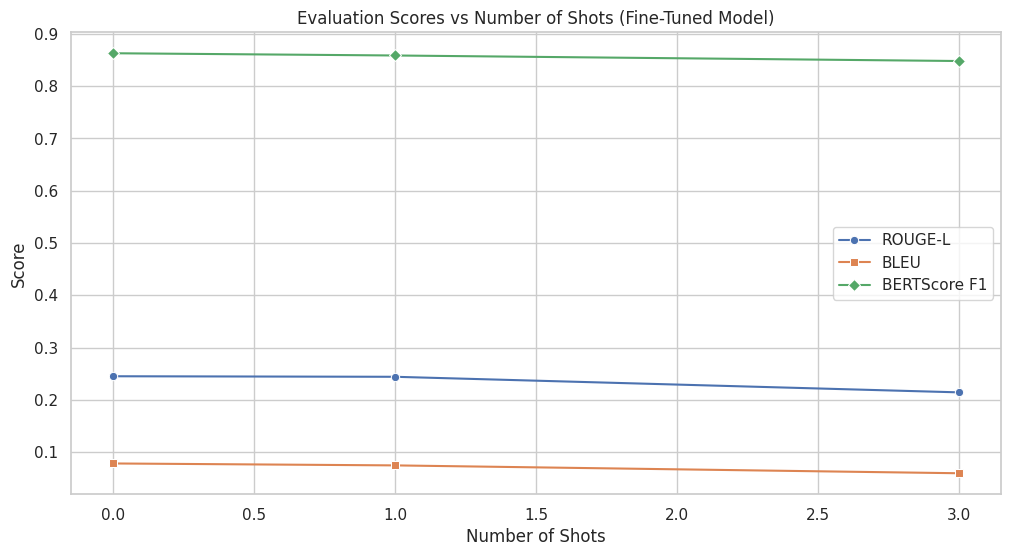

In [26]:
df_metrics_summary = pd.DataFrame(all_benchmark_results)
df_metrics_summary["model_short"] = df_metrics_summary["model"].apply(lambda x: x.split("/")[-1])

print("\n--- Benchmark Metrics Summary ---")
display(df_metrics_summary[["model_short", "shots", "rougeL", "bleu", "bertscore_f1"]].round(4))

import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_metrics_summary, x="shots", y="rougeL", marker="o", label="ROUGE-L")
sns.lineplot(data=df_metrics_summary, x="shots", y="bleu", marker="s", label="BLEU")
sns.lineplot(data=df_metrics_summary, x="shots", y="bertscore_f1", marker="D", label="BERTScore F1")
plt.title("Evaluation Scores vs Number of Shots (Fine-Tuned Model)")
plt.xlabel("Number of Shots")
plt.ylabel("Score")
plt.legend()
plt.show()